Connected to tracking-barbell-exercises (Python 3.8.15)

In [1]:
import sys
sys.path.append("../src")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from features.DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error
pd.options.mode.chained_assignment = None

# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../data/interim/01_data_precessed.pkl")
df = df.query('label!="rest"')

acc_r = df["acc_x"].pow(2) + df["acc_y"].pow(2) + df["acc_z"].pow(2)
gyr_r = df["gyr_x"].pow(2) + df["gyr_y"].pow(2) + df["gyr_z"].pow(2)
df["acc_r"] = acc_r.pow(0.5)
df["gyr_r"] = gyr_r.pow(0.5)

# --------------------------------------------------------------
# Split data by the exercise
# --------------------------------------------------------------
bench_df = df.query('label =="bench"')
squat_df = df.query('label =="squat"')
row_df = df.query('label =="row"')
ohp_df = df.query('label =="ohp"')
dead_df = df.query('label =="dead"')

In [2]:
plot_df = bench_df

<AxesSubplot: xlabel='epoch (ms)'>

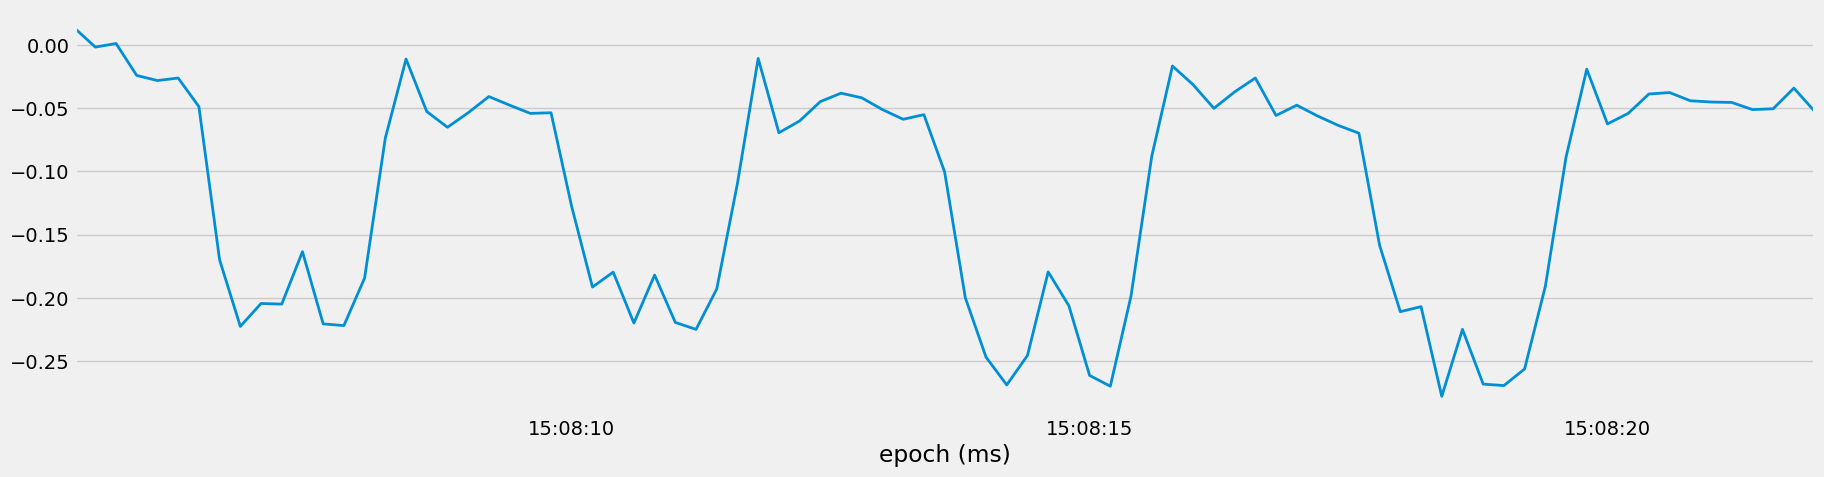

In [3]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_x"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

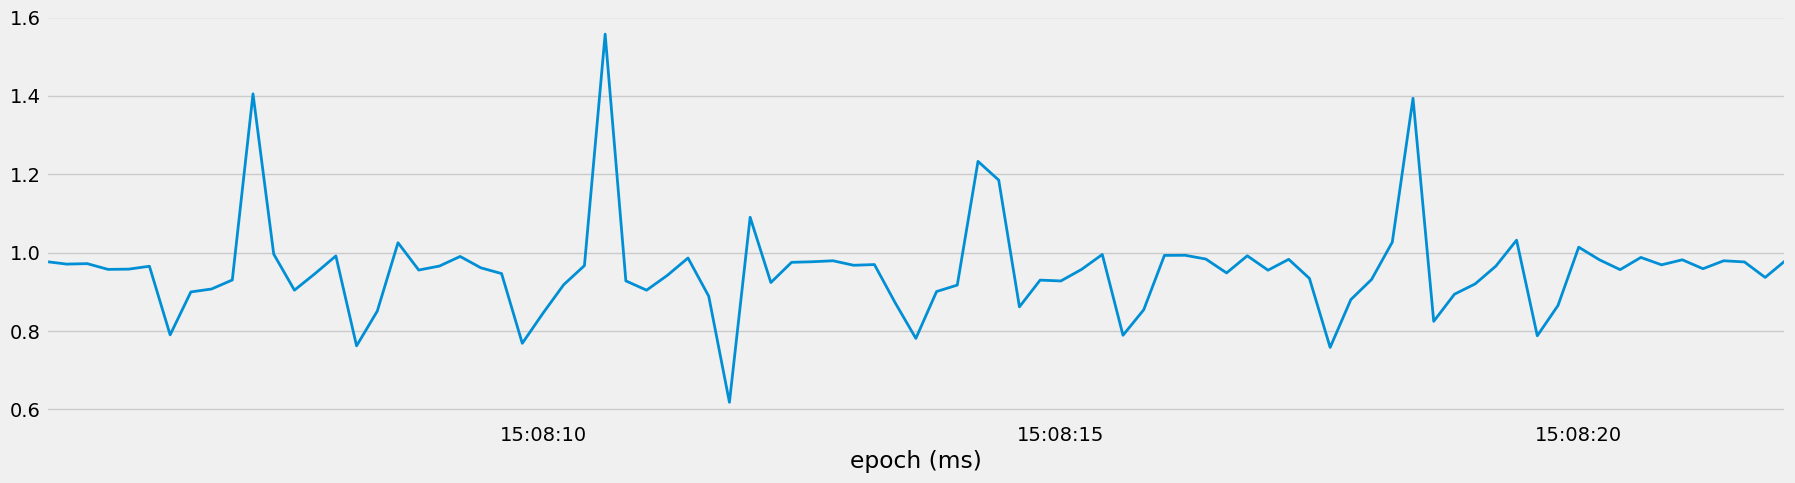

In [4]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_y"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

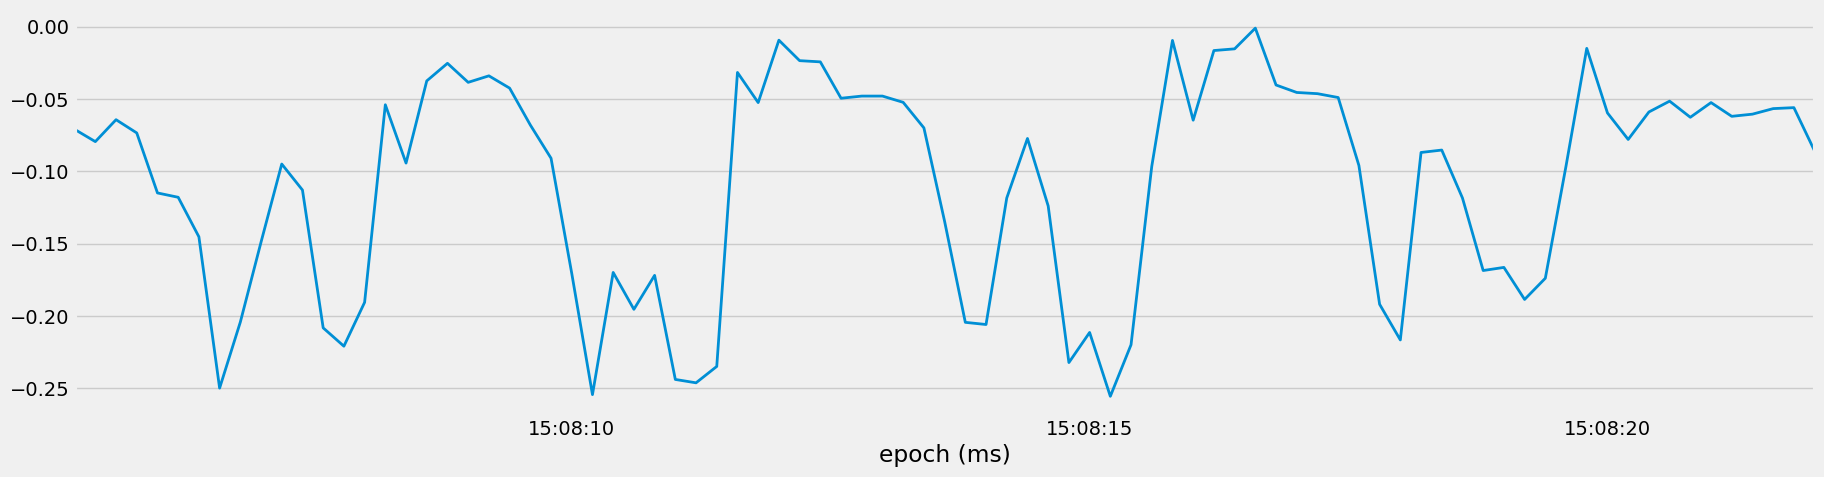

In [5]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_z"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

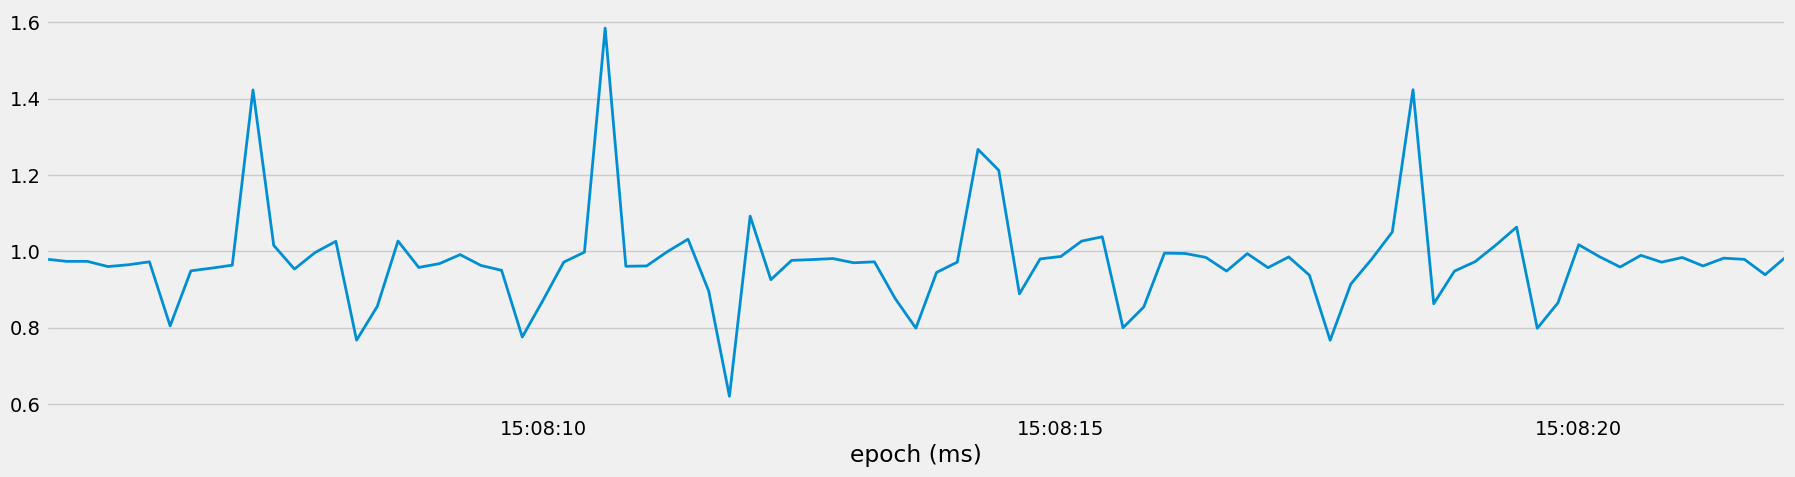

In [6]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_r"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

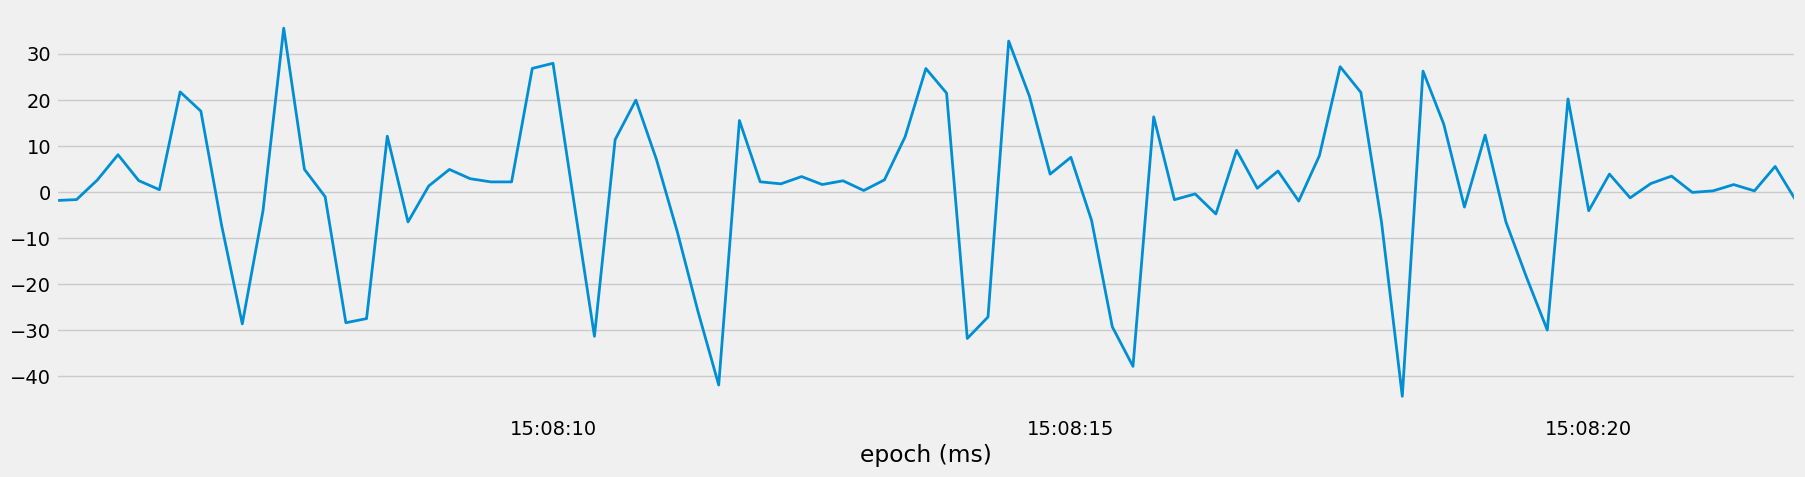

In [7]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_x"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

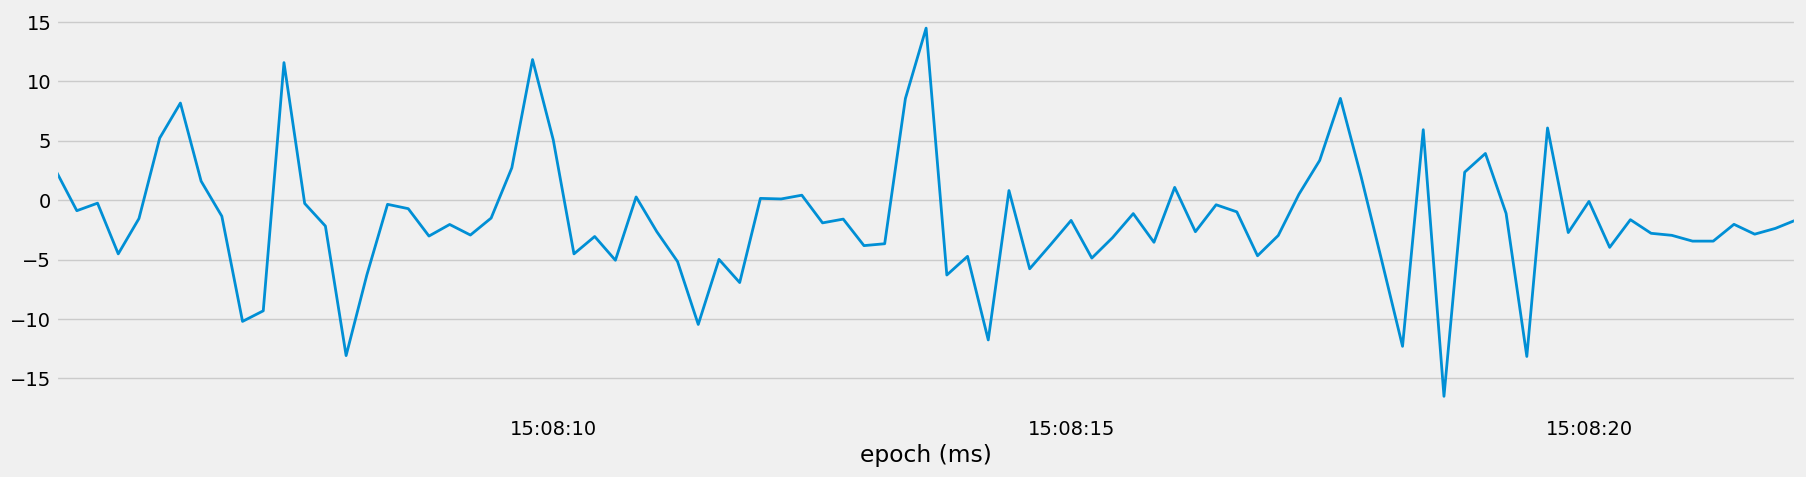

In [8]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_y"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

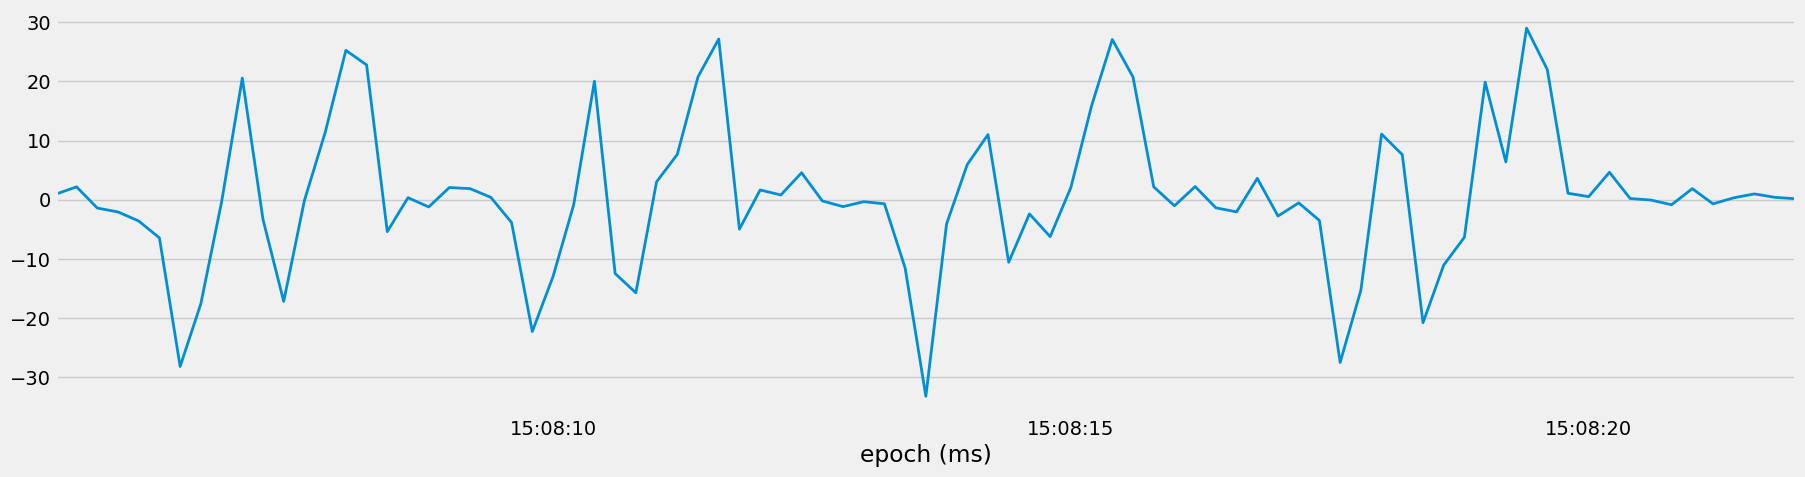

In [9]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_z"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

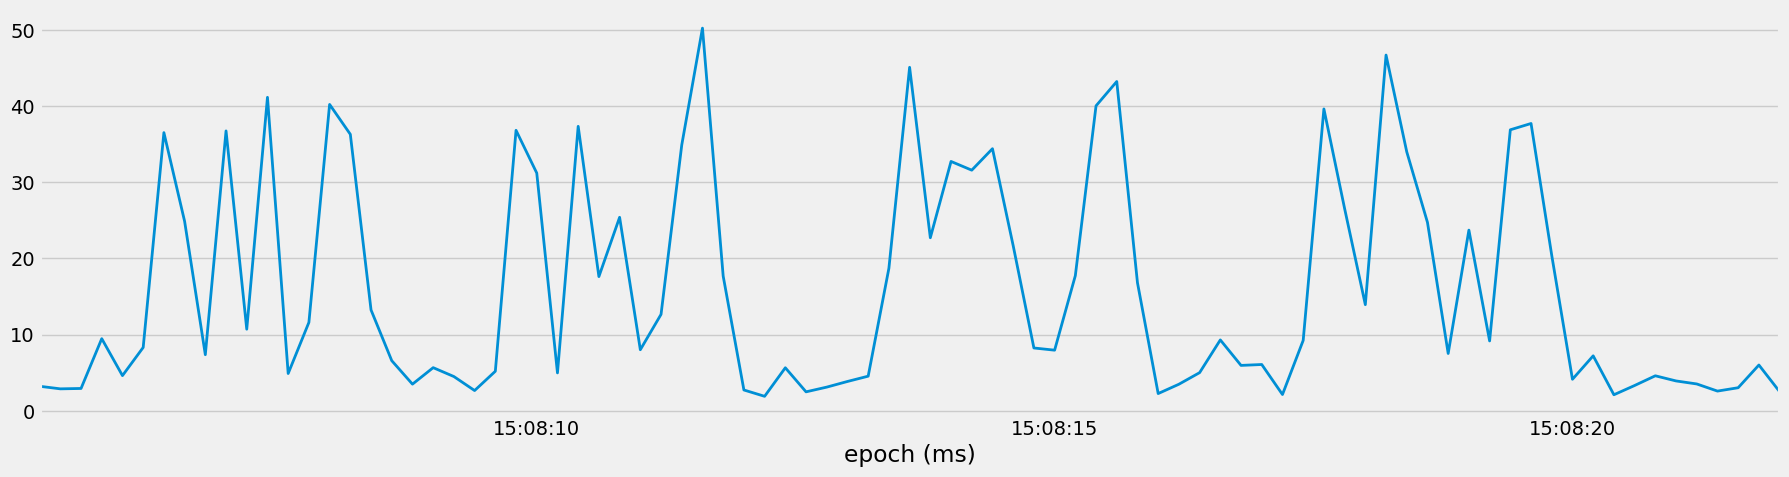

In [10]:
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_r"].plot()

In [11]:
fs = 1000 / 200
LowPass = LowPassFilter()

# --------------------------------------------------------------
# Apply and tweak LowPassFilter
# --------------------------------------------------------------
bench_set = bench_df[bench_df["set"] == bench_df["set"].unique()[0]]
squat_set = squat_df[squat_df["set"] == squat_df["set"].unique()[0]]
row_set = row_df[row_df["set"] == row_df["set"].unique()[0]]
ohp_set = ohp_df[ohp_df["set"] == ohp_df["set"].unique()[0]]
dead_set = dead_df[dead_df["set"] == dead_df["set"].unique()[0]]

<AxesSubplot: xlabel='epoch (ms)'>

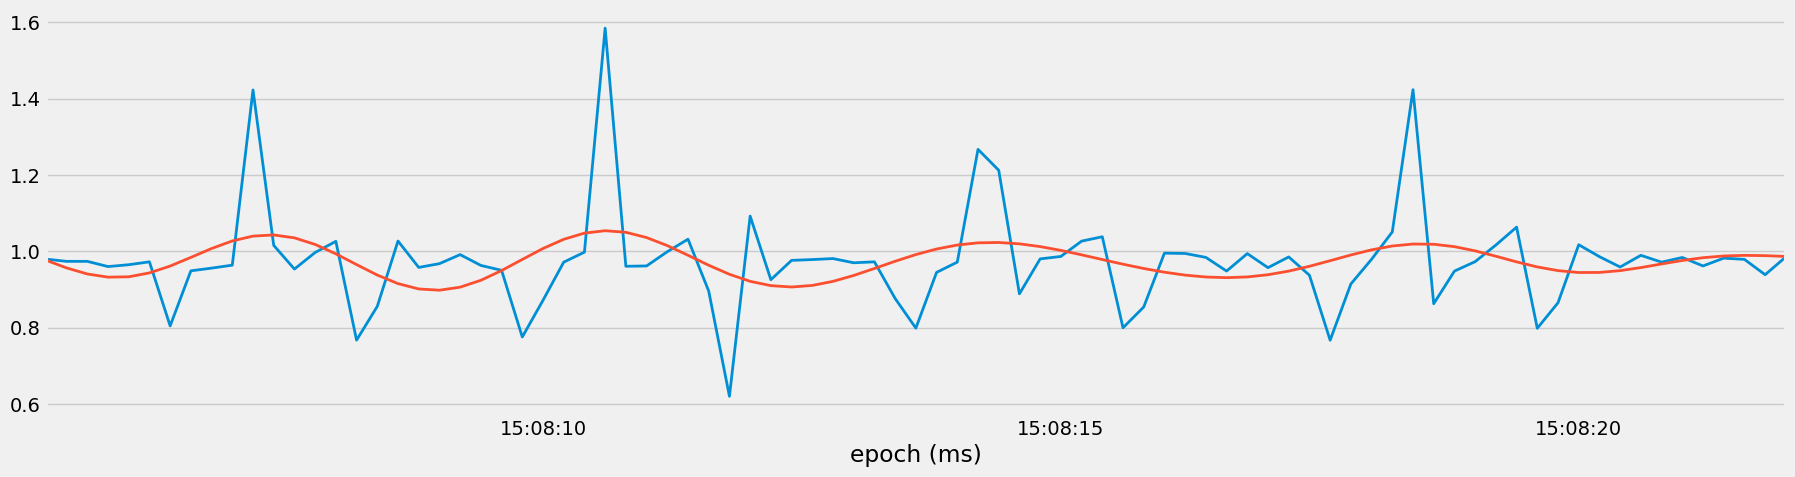

In [12]:
fs = 1000 / 200
LowPass = LowPassFilter()

# --------------------------------------------------------------
# Apply and tweak LowPassFilter
# --------------------------------------------------------------
bench_set = bench_df[bench_df["set"] == bench_df["set"].unique()[0]]
squat_set = squat_df[squat_df["set"] == squat_df["set"].unique()[0]]
row_set = row_df[row_df["set"] == row_df["set"].unique()[0]]
ohp_set = ohp_df[ohp_df["set"] == ohp_df["set"].unique()[0]]
dead_set = dead_df[dead_df["set"] == dead_df["set"].unique()[0]]
bench_set["acc_r"].plot()

column = "acc_r"
LowPass.low_pass_filter(
    bench_set, col=column, sampling_frequency=fs, cutoff_frequency=0.4, order=10
)[column + "_lowpass"].plot()

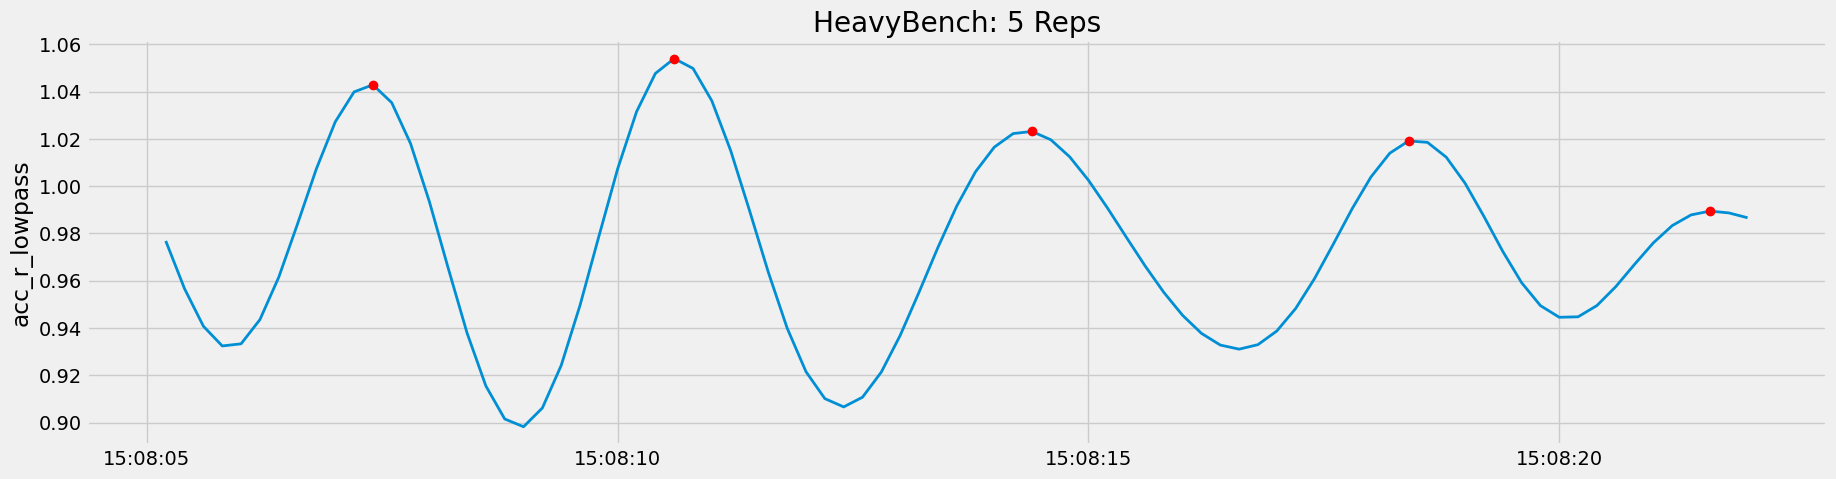

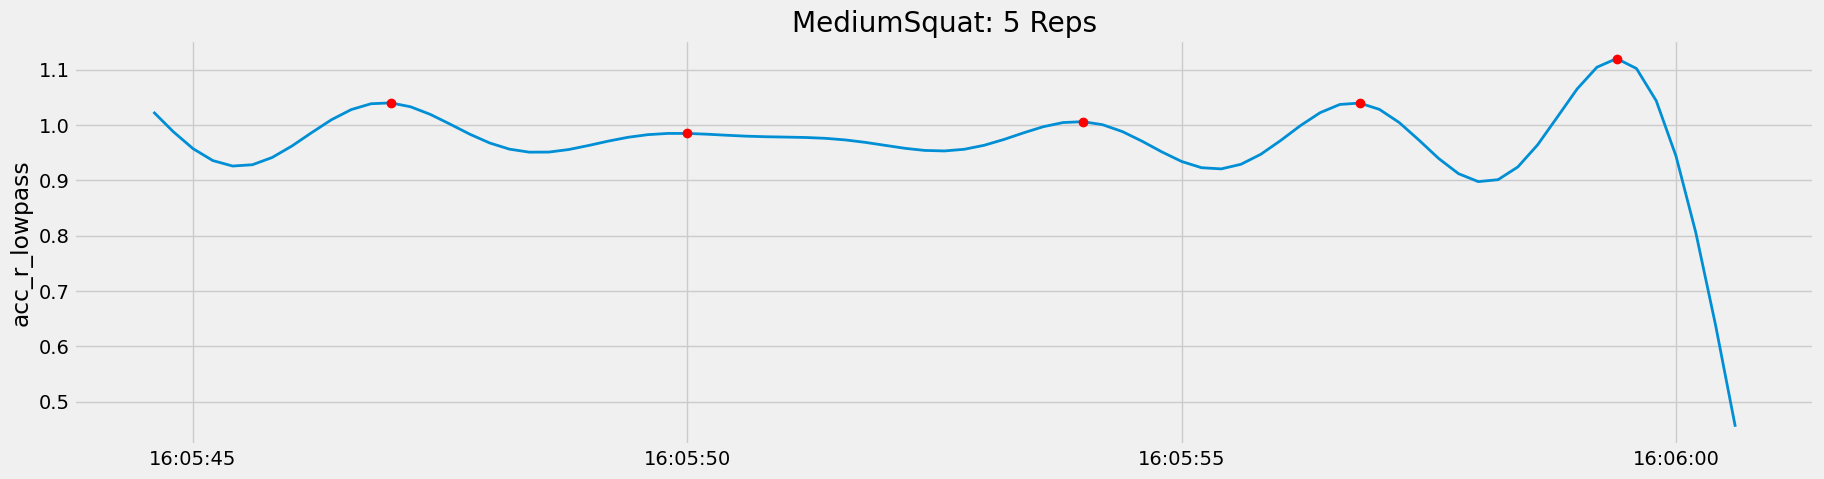

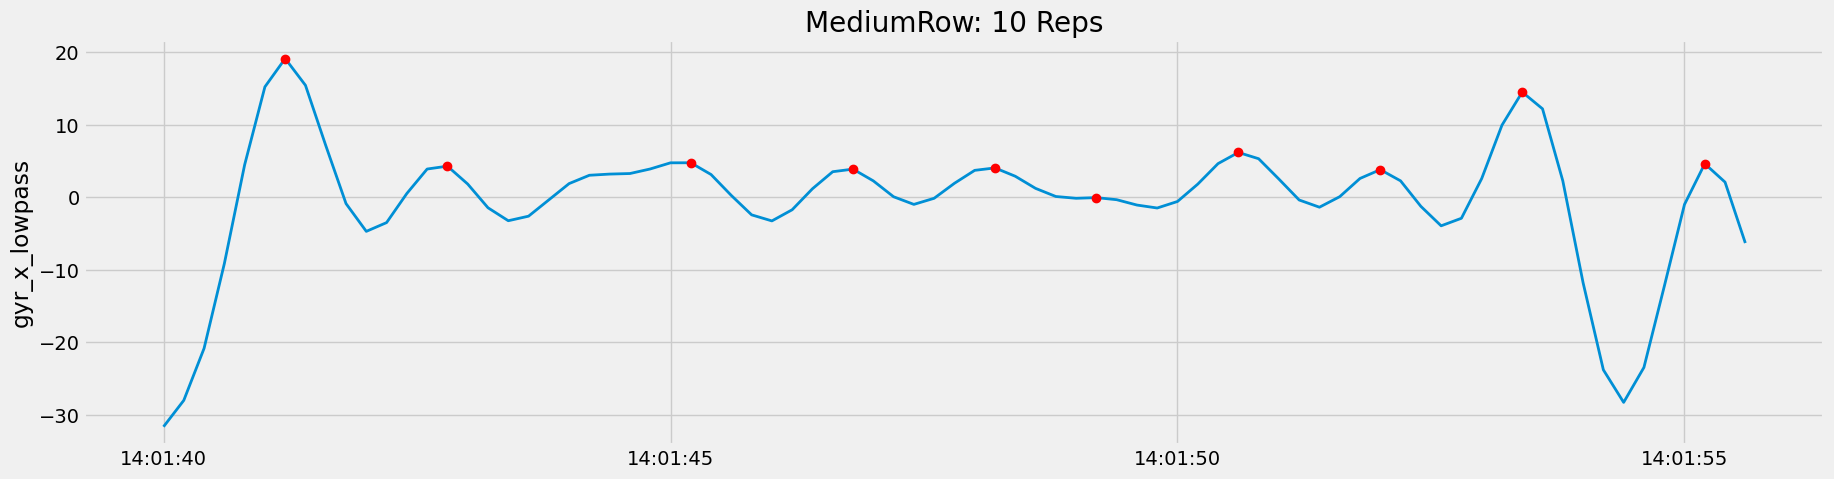

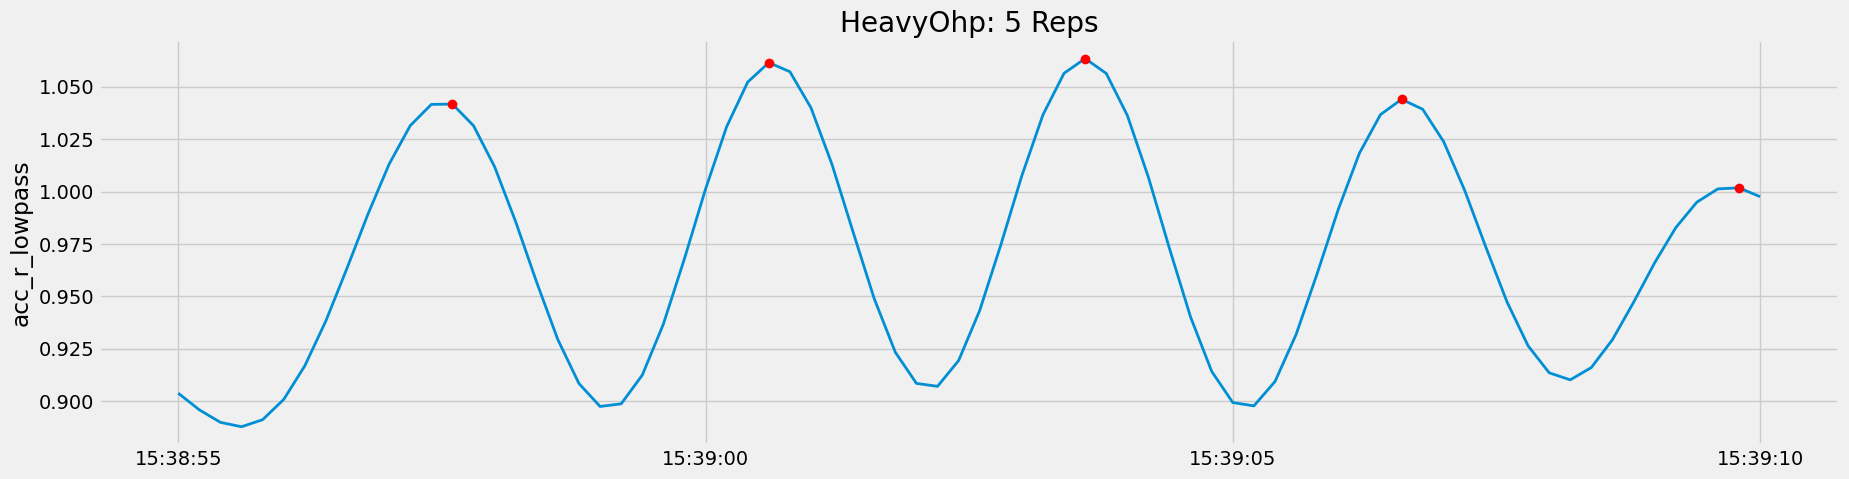

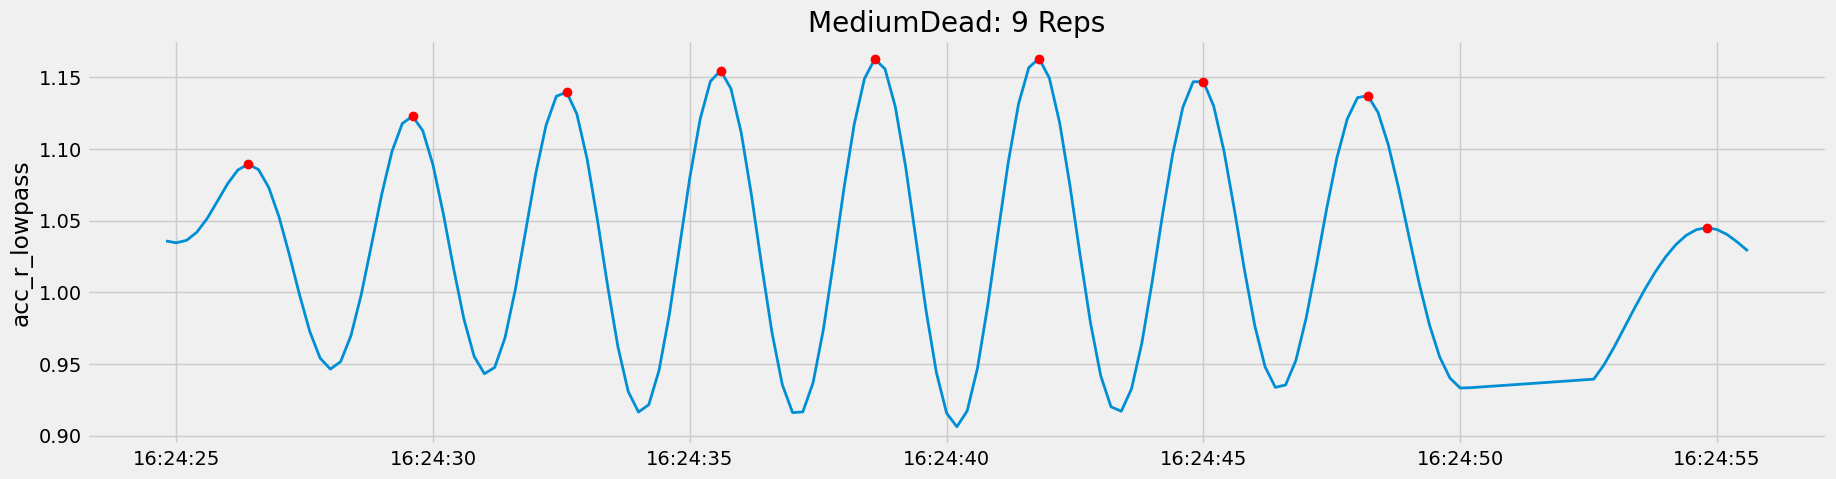

9

In [13]:
def count_reps(dataset, column="acc_r", fs=5.0, cutoff=0.4, order=10, show=True):
    data = LowPass.low_pass_filter(
        dataset, col=column, sampling_frequency=fs, cutoff_frequency=cutoff, order=order
    )
    indixes = argrelextrema(data[column + "_lowpass"].values, np.greater)
    peaks = data.iloc[indixes]
    
    if show:
        fig, ax = plt.subplots()
        plt.plot(dataset[f"{column}_lowpass"])
        plt.plot(peaks[f"{column}_lowpass"], "o", color="red")
        ax.set_ylabel(f"{column}_lowpass")
        exercise = dataset["label"].iloc[0].title()
        category = dataset["category"].iloc[0].title()
        plt.title(f"{category}{exercise}: {len(peaks)} Reps")
        plt.show()
        
    return len(peaks)

count_reps(bench_set, cutoff=0.4)
count_reps(squat_set, cutoff=0.35)
count_reps(row_set, cutoff=0.65, column="gyr_x")
count_reps(ohp_set, cutoff=0.35)
count_reps(dead_set, cutoff=0.35)

In [14]:
df["reps"] = df["category"].apply(lambda x: 5 if x == "heavy" else 10)
rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()
rep_df["reps_pred"] = 0

for s in df["set"].unique():
    subset = df.query("set == @s")
    column = "acc_r"
    cutoff = 0.4
    
    if subset["label"].iloc[0] == "suqat":
        cutoff = 0.35
        
    elif subset["label"].iloc[0] == "row":
        cutoff = 0.65
        col = "gyr_x"
        
    elif subset["label"].iloc[0] == "ohp":
        cutoff = 0.35
        
    reps = count_reps(subset, cutoff=cutoff, column=column, show=False)
    rep_df.loc[rep_df["set"] == s, "reps_pred"] = reps

rep_df

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,5
1,bench,heavy,2,5,4
2,bench,heavy,3,5,5
3,bench,heavy,4,5,5
4,bench,heavy,30,5,5
...,...,...,...,...,...
80,squat,medium,28,10,10
81,squat,medium,29,10,10
82,squat,medium,38,10,7
83,squat,medium,63,10,11


<AxesSubplot: xlabel='label,category'>

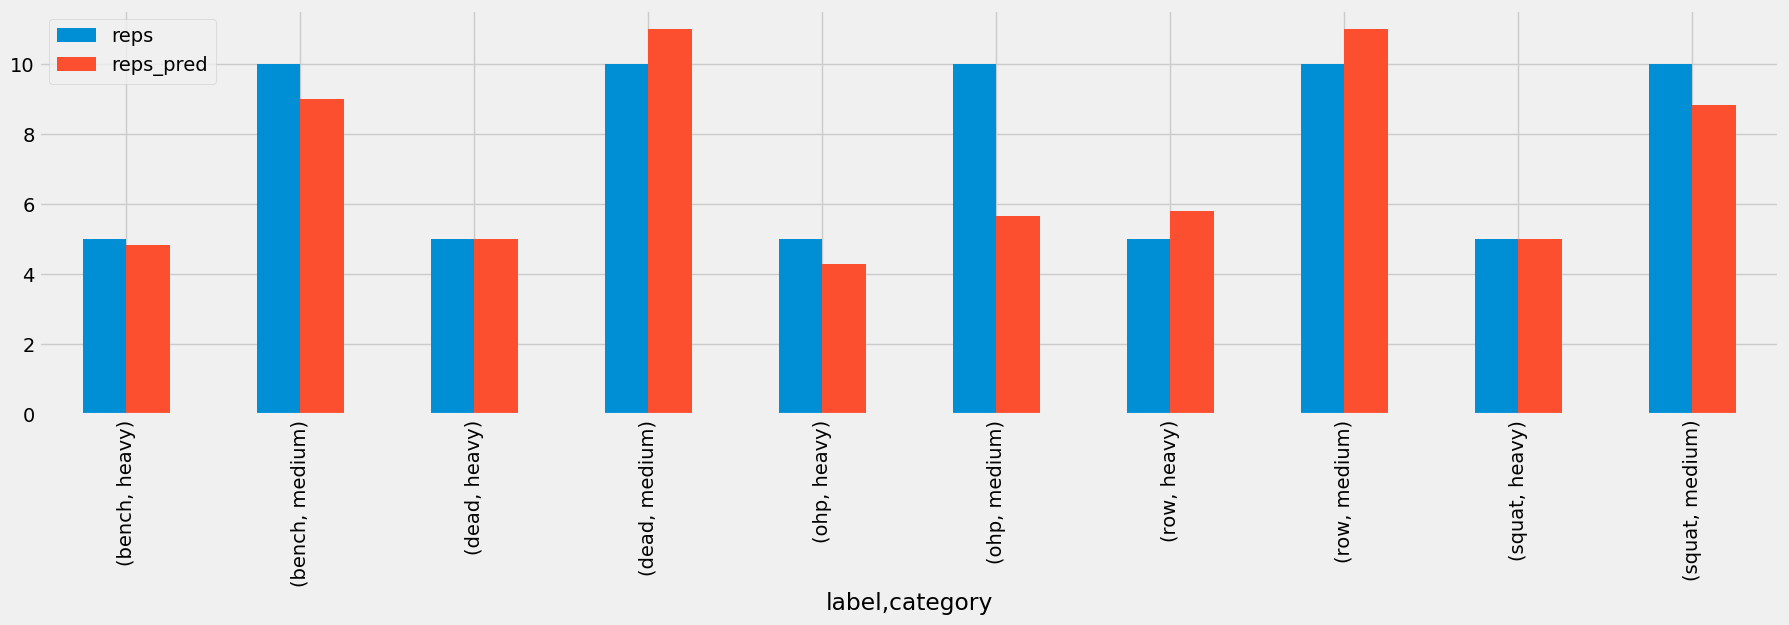

In [15]:
error = mean_absolute_error(rep_df["reps"], rep_df["reps_pred"]).round(2)
rep_df.groupby(["label", "category"])[["reps", "reps_pred"]].mean().plot.bar()